In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

/root/miniconda/envs/rep_py2/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


Data from [Kaggle](https://inclass.kaggle.com/c/comet-track-recognition-ysda-2016/data) are temporarily available via cernbox. Let's get it.

In [2]:
%%bash
if [ ! -d data ] ; then 
    wget https://cernbox.cern.ch/index.php/s/OuxEIMWpvA4ZlS7/download -O data.tgz && tar xzf data.tgz 
fi
ls -al data

total 495404
drwxr-xr-x 2 525264713 593637566      4096 Oct  6 14:14 .
drwxrwxr-x 4 root      root           4096 Oct  6 17:14 ..
-rw-r--r-- 1 525264713 593637566       578 Sep 22 17:47 ._sample_submission.csv
-rw-r--r-- 1 525264713 593637566       565 Sep 22 18:01 ._test.csv
-rw-r--r-- 1 525264713 593637566       570 Sep 22 18:00 ._train.csv
-rw-r--r-- 1 525264713 593637566       566 Sep 22 17:44 ._wires.csv
-rw-r--r-- 1 525264713 593637566  33766823 Sep 22 17:47 sample_submission.csv
-rw-r--r-- 1 525264713 593637566 237873474 Sep 22 18:01 test.csv
-rw-r--r-- 1 525264713 593637566 235515093 Sep 22 18:00 train.csv
-rw-r--r-- 1 525264713 593637566    106657 Sep 22 17:44 wires.csv


wget: /root/miniconda/envs/rep_py2/lib/libcrypto.so.1.0.0: no version information available (required by wget)
wget: /root/miniconda/envs/rep_py2/lib/libssl.so.1.0.0: no version information available (required by wget)
--2016-10-06 17:14:27--  https://cernbox.cern.ch/index.php/s/OuxEIMWpvA4ZlS7/download
Resolving cernbox.cern.ch (cernbox.cern.ch)... 188.184.3.40
Connecting to cernbox.cern.ch (cernbox.cern.ch)|188.184.3.40|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 142410897 (136M) [application/octet-stream]
Saving to: 'data.tgz'

     0K .......... .......... .......... .......... ..........  0%  403K 5m45s
    50K .......... .......... .......... .......... ..........  0%  404K 5m45s
   100K .......... .......... .......... .......... ..........  0%  799K 4m48s
   150K .......... .......... .......... .......... ..........  0%  812K 4m18s
   200K .......... .......... .......... .......... ..........  0%  808K 4m1s
   250K .......... .......... .........

In [3]:
hits_train = pd.read_csv("data/train.csv", index_col='global_id')
hits_train.head()

,event_id,wire_id,energy_deposit,relative_time,label
global_id,,,,,
0,0,0,0.000000e+00,0.000000,0
1,0,1,0.000000e+00,0.000000,0
2,0,2,0.000000e+00,0.000000,0
3,0,3,0.000000e+00,0.000000,0
4,0,4,1.178108e-08,22.224176,2


In [4]:
hits_test = pd.read_csv("data/test.csv", index_col='global_id')
hits_test.head()

,event_id,wire_id,energy_deposit,relative_time
global_id,,,,
7619400,1700,0,0.000000,0.000000
7619401,1700,1,0.000000,0.000000
7619402,1700,2,0.000000,0.000000
7619403,1700,3,0.000061,515.932708
7619404,1700,4,0.000000,0.000000


# Naive manual analysis
Obviously a not-so-good algorithm, used primaraly for illustrating IPython

First, check whether a a signal wire can have energy_deposit = 0

In [5]:
set(hits_train.loc[(hits_train.energy_deposit == 0)].label)

{0}

It can't! So far so good.

In [6]:
candidates = hits_train.loc[(hits_train.energy_deposit > 0)]

Try plotting time vs. energy vs. label. It's too big, so we'll take a sample. 

In [7]:
plot_sample_indices = np.random.choice(np.arange(len(candidates)), size=50000)
hits_to_plot = candidates.iloc[plot_sample_indices]

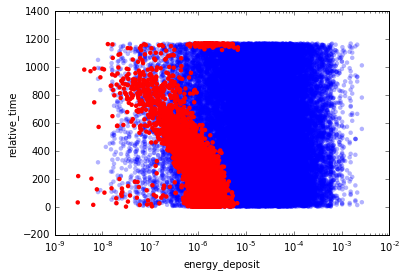

In [8]:
fig, ax = plt.subplots()
signal_hits = hits_to_plot.loc[(hits_to_plot.label == 1)]
noise_hits = hits_to_plot.loc[(hits_to_plot.label == 2)]
ax.scatter(noise_hits.energy_deposit, noise_hits.relative_time, c='b', edgecolors='none', alpha=0.3)
ax.scatter(signal_hits.energy_deposit, signal_hits.relative_time, c='r', edgecolors='none')
ax.set_xscale('log')
ax.set_xlim(1e-9, 1e-2)
ax.set_xlabel("energy_deposit")
ax.set_ylabel("relative_time")

Looks like we could use a selection rule.

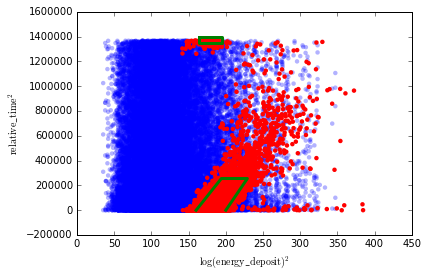

In [9]:
fig, ax = plt.subplots()
ax.scatter(np.log(noise_hits.energy_deposit)**2, noise_hits.relative_time**2, c='b', edgecolors='none', alpha=0.3)
ax.scatter(np.log(signal_hits.energy_deposit)**2, signal_hits.relative_time**2, c='r', edgecolors='none')
high_relative_time = 1.35e6
low_relative_time = 256300
low_points = np.array([[160, 0], [194, low_relative_time], [229, low_relative_time], [200, 0]])
high_points = np.array([[164, 1.4e6], [195, 1.4e6], [195, high_relative_time], [164, high_relative_time],
                        [164, 1.4e6]])
ax.plot(low_points[:, 0], low_points[:, 1], 'g', lw=3)
ax.plot(high_points[:, 0], high_points[:, 1], 'g', lw=3)
ax.set_xlabel(r"$\log(\mathrm{energy\_deposit})^2$")
ax.set_ylabel(r"$\mathrm{relative\_time}^2$")

In [11]:
top_line_coeffs = np.polyfit(low_points[0:2, 0], low_points[0:2, 1], deg=1)
bottom_line_coeffs = np.polyfit(low_points[2:4, 0], low_points[2:4, 1], deg=1)
def is_signal(event):
    log_energy_squared = np.log(event.energy_deposit)**2
    relative_time_squared = event.relative_time**2
    return (((relative_time_squared < low_relative_time) & (
            relative_time_squared < np.poly1d(top_line_coeffs)(log_energy_squared)) & (
                relative_time_squared > np.poly1d(bottom_line_coeffs)(log_energy_squared))) | 
            ((relative_time_squared > high_relative_time) & 
             (log_energy_squared > 164) & (log_energy_squared < 195)))        

Also, np.log(0) is -inf. And it is correcly handled.

In [12]:
np.log(0)

-inf

In [13]:
hits_train.iloc[1]

event_id          0
wire_id           1
energy_deposit    0
relative_time     0
label             0
Name: 1, dtype: float64

In [14]:
is_signal(hits_train.iloc[1])

False

Check how good the model describes the data.

In [15]:
from sklearn.metrics import roc_auc_score
hits_train_is_signal = (hits_train.label == 1)
roc_auc_score(hits_train_is_signal, is_signal(hits_train))

0.88085694017473237

Let's make a predicion for submission. Take note at the format: only the events with positive energy.

In [16]:
prediction = pd.DataFrame({"prediction": is_signal(hits_test.loc[hits_test.energy_deposit > 0]).astype(np.int)})

In [17]:
prediction.to_csv("naive_manual_prediction.csv", index_label='global_id')

Download your predictions from the cluster.

In [18]:
from IPython.display import FileLink
FileLink("naive_manual_prediction.csv")

/notebooks/comet-starterkit/naive_manual_prediction.csv

# Naive machine learning

In [19]:
from sklearn.tree import DecisionTreeClassifier

CV might take some time

In [20]:
from sklearn.cross_validation import cross_val_score
cv_gini = cross_val_score(DecisionTreeClassifier(criterion='gini'),
                hits_train[['energy_deposit', 'relative_time']].values, (hits_train.label == 1).values.astype(np.int),
               scoring='roc_auc')
print(cv_gini.mean(), cv_gini.std())

(0.81292028130725968, 0.0014277098133228007)


In [21]:
cv_entropy = cross_val_score(DecisionTreeClassifier(criterion='entropy'),
                hits_train[['energy_deposit', 'relative_time']].values, (hits_train.label == 1).values.astype(np.int),
                scoring='roc_auc')
print(cv_entropy.mean(), cv_entropy.std())

(0.81037191065193903, 0.00086630616428034568)


In [22]:
classifier = DecisionTreeClassifier(criterion='gini')
classifier.fit(hits_train[['energy_deposit', 'relative_time']], (hits_train.label == 1))

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best')

In [23]:
candidates = hits_test.loc[hits_test.energy_deposit > 0]
ml_prediction = pd.DataFrame({
        "prediction": classifier.predict_proba(candidates[[
                    'energy_deposit', 'relative_time']])[:, 1]}, index=candidates.index)

In [24]:
ml_prediction.to_csv("naive_ml_prediction.csv", index_label='global_id')

Moral: sometimes you can outdo simple machine learning by thinking. Corollary: the best result is achieved by combining the approaches.

In [25]:
FileLink("naive_ml_prediction.csv")

/notebooks/comet-starterkit/naive_ml_prediction.csv

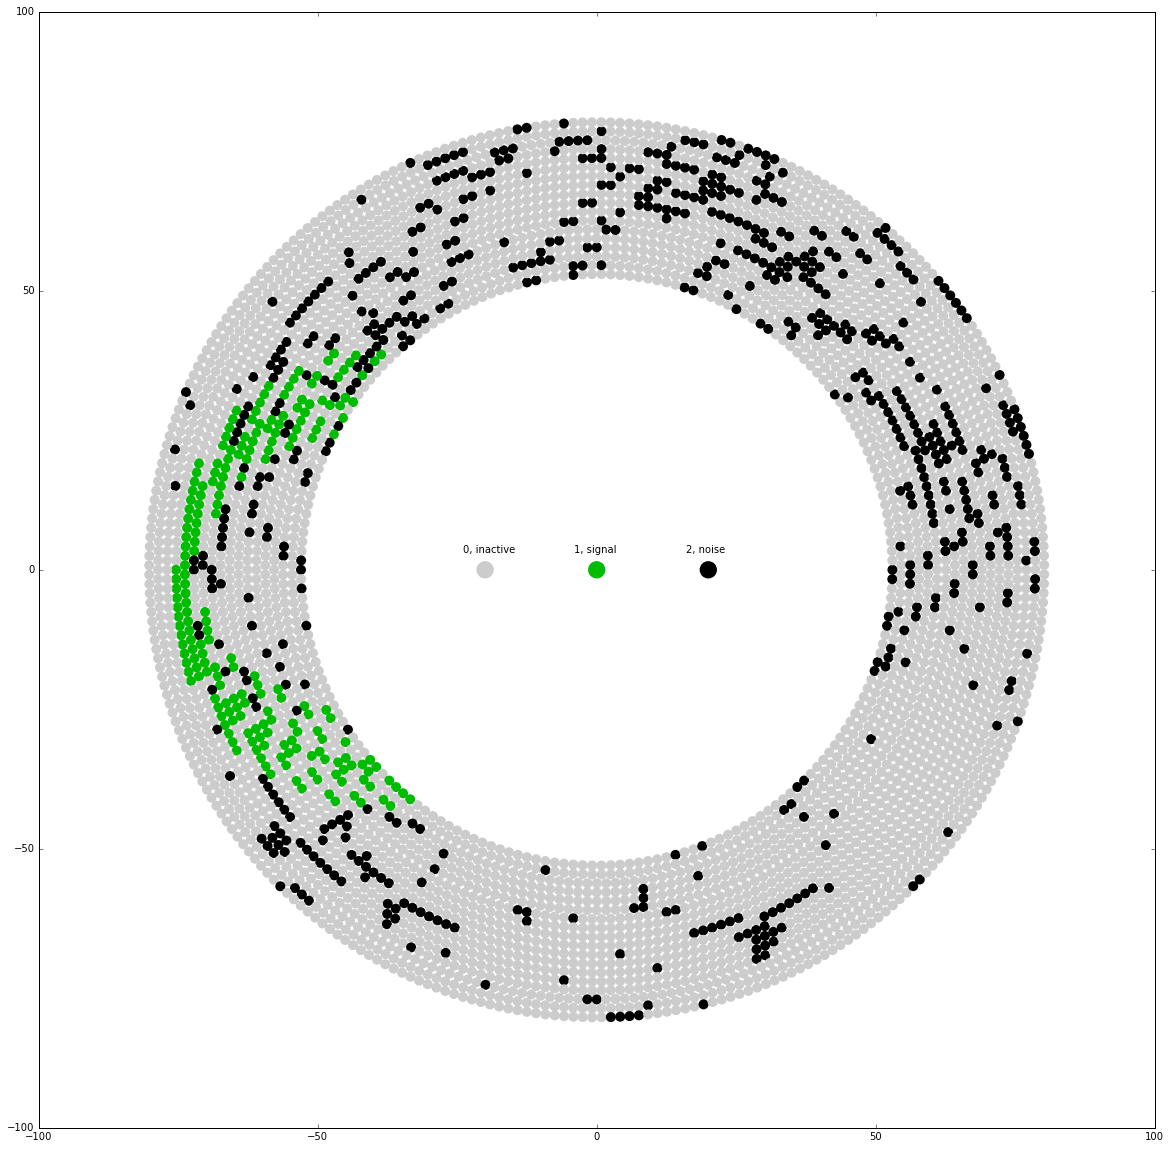

In [31]:
the_event = hits_train[hits_train.event_id==54]
fig, ax = plt.subplots(figsize=(20,20))
colormap = 'spectral'
wires = pd.read_csv('data/wires.csv')

wires_cartesian = np.vstack((wires['wire_rho'] * np.cos(wires['wire_phi']),
                                  wires['wire_rho'] * np.sin(wires['wire_phi']))).T

ax.scatter(wires_cartesian[:, 0], wires_cartesian[:, 1], c=2-the_event.label, edgecolors='none',
           s=100, cmap=colormap)
# We want to know what color corresponds to which label
labels_x = (-20, 0, 20)
ax.scatter(labels_x, (0, 0, 0), c=(2, 1, 0), cmap=colormap, edgecolors='none', s=300)
for label, coordinate in zip(("0, inactive", "1, signal", "2, noise"), labels_x):
    ax.annotate(label, xy=(coordinate-4, 3))


### Energy deposits

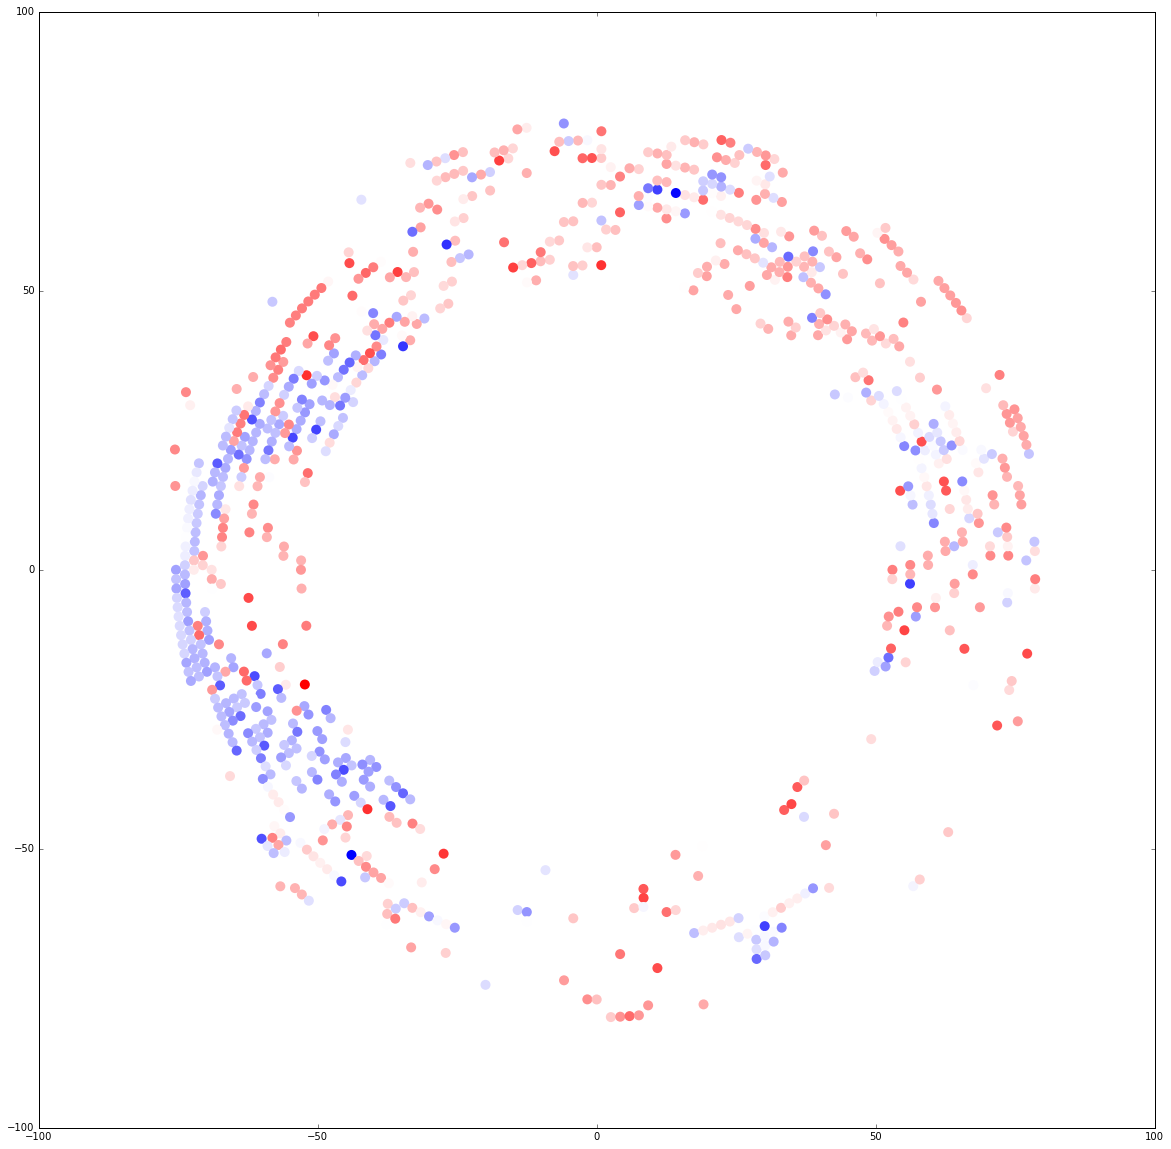

In [32]:
fig, ax = plt.subplots(figsize=(20,20))
ax.scatter(wires_cartesian[:, 0], wires_cartesian[:, 1], c=np.log(the_event.energy_deposit), edgecolors='none',
           s=100, cmap='bwr')